# 개요

Scikit-learn에서는 중요도를 측정하는 기준으로 크게 coefficient와 feature importance를 사용합니다. 회귀 모델의 linear regression, 분류 모델의 logistic regression에서 coefficient가 큰 변수일수록 label 결정 즉 prediction에 미치는 영향력이 큽니다. 이는 수식을 통해서 쉽게 파악할 수 있습니다.

* Linear regression:  $\large Y = \beta_0 + \beta_1 x_1 + \cdots + \beta_p x_p + \varepsilon$

* Logistic regression:  $\large \displaystyle \ln{\left(\frac{\pi}{1-\pi}\right)} = \beta_0 + \beta_1 x_1 + \cdots + \beta_p x_p$ where $\large \pi = P(Y=1\mid X=\mathbf{x})$

그에 비해 decision tree, random forest 등 tree-based 알고리즘에서는 feature importance attribute를 제공합니다. 변수가 tree의 성장 즉 분기에 미치는 영향력의 정도가 0과 1 사이의 실수로 표현되며 모든 importances의 합은 1입니다. regression 모델의 coefficient는 '다항식의 계수'라는 점에서 수식을 보면 직관적으로 파악할 수 있습니다. 그러나 feature importance 개념은 계산식뿐만 아니라 tree-based 알고리즘의 원리, 불순도(impurity) 등을 종합적으로 이해하고 있어야 접근 가능합니다.

본 포스트에서는 간단한 decision tree 모델을 설정하고 그 모델이 학습하는 과정을 따라가며 불순도와 feature importace를 설명하겠습니다. 더불어 feature importance를 계산하는 코드를 직접 구현해보고 그 결과를 scikit-learn의 decision tree, random forest 모델 attribute의 결과와 비교함으로써 검증해보겠습니다.

# 필요한 라이브러리와 데이터 불러오기

Numpy, Pandas, matplotlib 그리고 scikit-learn에서 샘플 데이터(보스턴 주택 가격), decision tree, random forest regression model 등을 불러옵니다.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.datasets import load_boston
from sklearn.tree import plot_tree, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
data = load_boston()

X = data['data']
y = data['target']
feature_names = data['feature_names']

데이터를 train과 test set으로 분할합니다.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Decision Tree

## 모델 선언

tree를 시각화해보면 알고리즘을 이해하는 데 도움이 됩니다. 모델이 복잡하면 tree를 그렸을 때 어지럽기 때문에 간단한 decision tree 모델을 선언합니다. leaf nodes가 10개가 되면 성장을 멈춥니다.

In [4]:
model_dt = DecisionTreeRegressor(max_leaf_nodes=10, random_state=42)
model_dt.fit(X_train, y_train)

pred_dt = model_dt.predict(X_test)
print('MAE:',mean_absolute_error(y_test, pred_dt))
print('R2:',r2_score(y_test, pred_dt))

MAE: 2.8483319418325292
R2: 0.813134366573089


## Selecting features and threshold as criteria for split

In [11]:
train = pd.DataFrame(np.hstack((X_train, y_train.reshape(-1,1))), columns=feature_names.tolist()+['label'])

In [54]:
n = train.shape[0]
dic= dict()
for col in feature_names:
    tr = train[[col, 'label']]
    nt = tr.shape[0]
    i0 = tr['label'].var()
    values = np.unique(tr[col])
    if values.size==1:
        continue
    thresholds = np.array([values[i:i+2].mean() for i in range(values.size-1)])[::-1]
    #thresholds =[ np.median(thresholds)]
    if values.size <=10:
        iter_lim = thresholds.size
    else:
        iter_lim = thresholds.size//3
    
    i_ = 0
    th_tag = 0
    lim = 0
    for th in thresholds:
        trr = tr[(tr[col]>th)]
        ntr = trr.shape[0]
        ir = trr['label'].var()
        
        trl = tr[tr[col]<=th]
        ntl = trl.shape[0]
        il = trl['label'].var()
        
        i = (nt / n) * ( i0 - (ntl / nt) * il - (ntr / nt)* ir )
        
        if i > i_:
            i_ = i
            th_tag = th
        
        lim+=1
        if lim==iter_lim:
            break
            
    dic[col] = (i_, th_tag)

In [61]:
train1 = train[train['RM']>6.941]
dic= dict()
for col in feature_names:
    tr = train1[[col, 'label']]
    nt = tr.shape[0]
    i0 = tr['label'].var()
    values = np.unique(tr[col])
    if values.size==1:
        continue
    thresholds = np.array([values[i:i+2].mean() for i in range(values.size-1)])[::-1]
    #thresholds =[ np.median(thresholds)]
    if values.size <=10:
        iter_lim = thresholds.size
    else:
        iter_lim = thresholds.size//2
    
    i_ = 0
    th_tag = 0
    lim = 0
    for th in thresholds:
        trr = tr[(tr[col]>th)]
        ntr = trr.shape[0]
        ir = trr['label'].var()
        
        trl = tr[tr[col]<=th]
        ntl = trl.shape[0]
        il = trl['label'].var()
        
        i = (nt / n) * ( i0 - (ntl / nt) * il - (ntr / nt)* ir )
        
        if i > i_:
            i_ = i
            th_tag = th
        
        lim+=1
        if lim==iter_lim:
            break
            
    dic[col] = (i_, th_tag)

In [62]:
print(max(dic, key = lambda x: dic[x][0]), dic[max(dic, key = lambda x: dic[x][0])][1])

RM 7.436999999999999


In [34]:
train1 = train[train['RM']<=6.941]
dic= dict()
for col in feature_names:
    tr = train1[[col, 'label']]
    nt = tr.shape[0]
    i0 = tr['label'].var()
    values = np.unique(tr[col])
    if values.size==1:
        continue
    thresholds = np.array([values[i:i+2].mean() for i in range(values.size-1)])
    
    i_ = 0
    th_tag = 0
    for th in thresholds:
        trr = tr[(tr[col]>th)]
        ntr = trr.shape[0]
        ir = trr['label'].var()
        
        trl = tr[tr[col]<=th]
        ntl = trl.shape[0]
        il = trl['label'].var()
        
        i = (nt / n) * ( i0 - (ntl / nt) * il - (ntr / nt)* ir )
        
        if i > i_:
            i_ = i
            th_tag = th
            
    dic[col] = (i_, th_tag)
    
max(dic, key = lambda x: dic[x][0])

'LSTAT'

In [29]:
train2 = train[train['RM']>6.941]
dic= dict()
for col in feature_names:
    tr = train2[[col, 'label']]
    nt = tr.shape[0]
    i0 = tr['label'].var()
    values = np.unique(tr[col])
    if values.size==1:
        continue
    thresholds = np.array([values[i:i+2].mean() for i in range(values.size-1)])
    
    i_ = 0
    th_tag = 0
    for th in thresholds:
        trr = tr[(tr[col]>th)]
        ntr = trr.shape[0]
        ir = trr['label'].var()
        
        trl = tr[tr[col]<=th]
        ntl = trl.shape[0]
        il = trl['label'].var()
        
        i = (nt / n) * ( i0 - (ntl / nt) * il - (ntr / nt)* ir )
        
        if i > i_:
            i_ = i
            th_tag = th
            
    dic[col] = (i_, th_tag)

In [28]:
nt

337

In [30]:
dic

{'CRIM': (2.676468154627966, 7.393425),
 'ZN': (0.04823255539839649, 21.0),
 'INDUS': (1.633127800484966, 18.84),
 'CHAS': (0, 0),
 'NOX': (3.206262019059046, 0.659),
 'RM': (5.933510883588361, 7.436999999999999),
 'AGE': (0.1331018179943038, 98.75),
 'DIS': (0.44490294029403366, 6.75885),
 'RAD': (1.4584021066041086, 16.0),
 'TAX': (1.4584021066041086, 534.5),
 'PTRATIO': (2.0807269726972724, 19.7),
 'B': (1.0056238165833398, 395.59000000000003),
 'LSTAT': (3.749319225841501, 4.68)}

## 시각화

시각화하면 아래와 같습니다. 각 node에서 어떤 feature를 기준으로 분기하고 각 node에 할당되는 샘플은 몇 개인지 등을 알 수 있습니다.

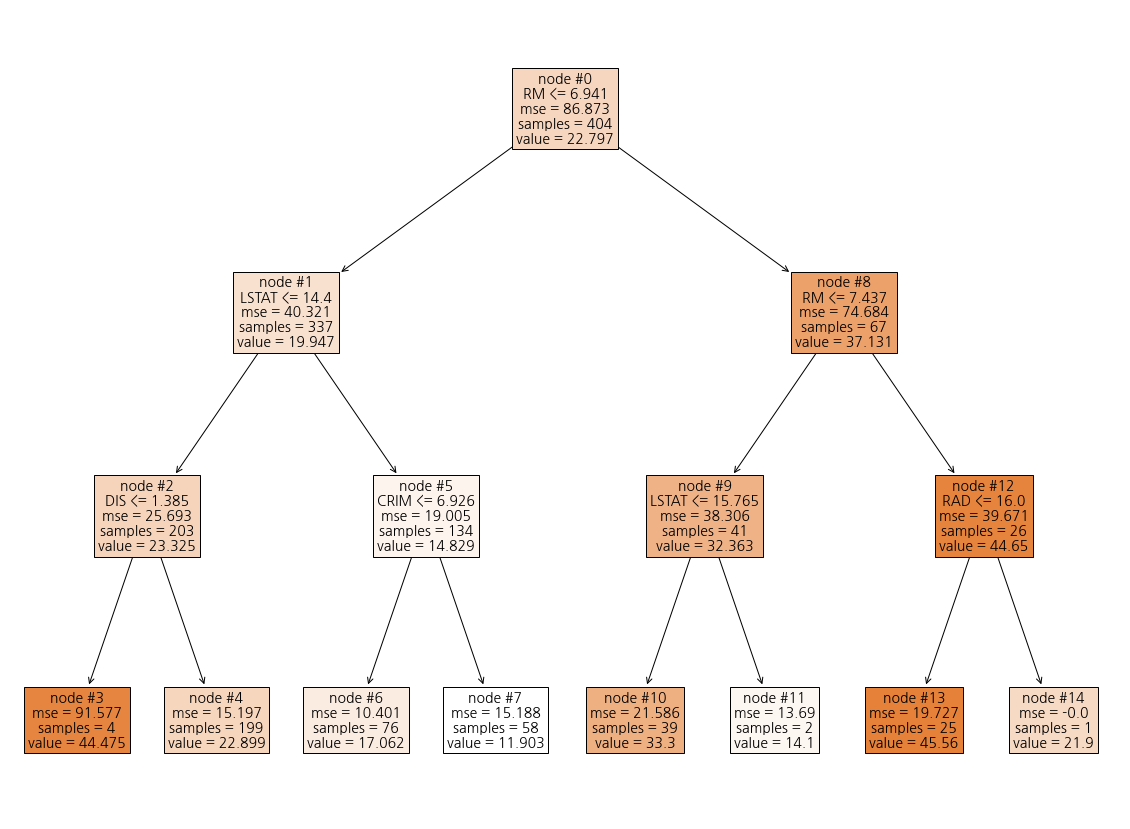

In [66]:
plt.figure(figsize=(20,15))
plot_tree(model_dt, node_ids=True, fontsize=14, feature_names=data['feature_names'], filled=True)
plt.show()

사각형은 각각의 node를 나타냅니다. 가장 꼭대기에 있는 node 0을 'root', 더이상 분기되지 않는 node를 'leaf'라고 합니다. 상위 node를 'parent', parent에서 분기되는 두 node를 'children'이라 부릅니다. 사각형 안에는 다섯 개 줄에 걸쳐 node의 정보가 표기되어 있습니다.

1. 첫째 줄: node 번호  
2. 둘째 줄: 분기 기준. information gain을 최대화하는 즉 impurity를 최소화하는 feature와 threshold를 선택하여 이를 기준으로 각 node에 할당되어 있는 학습 데이터 샘플을 나눕니다.  
3. 셋째 줄: impurity. 해당 node의 불순도입니다. 분류 모델의 경우 gini와 entropy, 회귀 모델의 경우 mse와 mae를 사용합니다. 우리 모델에서는 회귀 모델 default criterion인 mse가 쓰였습니다.  
  - 분류  
    - gini: $\large 1-\sum_{i=1}^{k} {p_i}^2$, $k$는 class의 개수, $p_i =$ (해당 노드에서 class i에 해당하는 샘플의 개수) $\div$ (해당 노드에 할당된 모든 샘플의 개수)  
    - entropy: $\large -\sum_{i=1}^{k} p_i \log{p_i}$  
  - 회귀
    - mse: $\large \sum_{i=1}^n (y_i - \bar{y})^2$, $n = $ 노드의 샘플 개수, $y_i = $ i번째 샘플의 label, $\bar{y} = $ 노드의 모든 샘플의 label 평균  
    - mae: $\large \sum_{i=1}^n |y_i - \bar{y}|$
4. 넷째 줄: node에 할당된 샘플의 개수  
5. 다섯째 줄: node의 샘플들에 할당되는 예측값  
  - 분류: class. 이진 분류 모델이라면 0 혹은 1  
  - 회귀: 샘플의 label의 평균
  
위 그림에서 확인할 수 있듯, 분기를 거듭할수록 불순도(우리 모델에서는 mse)가 감소합니다. feature importance란 이 '불순도'를 감소시키는 데 각 변수가 기여한 정도를 나타냅니다.

## Feature importance

각 노드를 지나면서 'weighted impurity decrease'가 계산됩니다. 부모 노드에 비해 자식 노드에서 불순도가 크게 감소할수록 값이 커집니다. 분기가 발생할 때마다 이 값은 해당 노드의 기준 feature로 누적됩니다. tree의 성장이 끝나면 feature importance가 산출됩니다. 계산식은 아래와 같습니다.

$\large \displaystyle \Delta I = \frac{n_t}{n} \left( I_t - \frac{n_{tl}}{n_t} I_{tl} - \frac{n_{tr}}{n_t} I_{tr} \right)$

- $n$: 모든 학습 데이터의 개수
- $n_t$: 부모 노드의 샘플 개수
- $n_{tl}$: 왼쪽 자식 노드의 샘플 개수
- $n_{tr}$: 오른쪽 자식 노드의 샘플 개수
- $I_{t}$: 부모 노드의 불순도
- $I_{tl}$: 왼쪽 자식 노드의 불순도
- $I_{tr}$: 오른쪽 자식 노드의 불순도

각 노드의 기준 feature, threshold, 샘플 개수, 자식 노드, 불순도 등의 정보에 접근하려면 `tree_` attribute를 사용합니다.

- `tree_.feature`: 각 노드에서 분기의 기준이 되는 feature의 순서. 불순도를 가장 크게 감소시킬 수 있는 feature를 선택한다.  
- `tree_.threshold`: 위 feature의 분기 역치(threshold value). 역시 불순도를 가장 크게 감소시키는 값을 고른다. 각 샘플의 feature 값이 threshold를 이하 혹은 초과인지에 따라 샘플을 왼쪽 혹은 오른쪽 자식 노드로 보낸다.  
- `tree_.impurity`: 노드의 불순도.  
- `tree_.children_left`: 노드의 왼쪽 자식 노드.  
- `tree_.children_right`: 노드의 오른쪽 자식 노드.  
- `tree_.n_node_samples`: 노드에 할당된 샘플 개수.  

위 공식에 따라 feature importace를 구하는 코드를 구현합니다. <u>**주의할 점**</u>은 각 노드의 샘플 개수를 구할 때 `tree_.n_node_samples`이 아닌 **`tree_.weighted_n_node_samples`** 를 사용해야 한다는 것입니다. decision tree 모델에서는 `fit`할 때 특별히 sample_weight를 지정하지 않고서는 양자의 결과값이 동일하나 random forest에서는 다릅니다. random forest에서는 기본적으로 bootstrap을 사용하므로 각 tree가 학습할 때 학습 데이터를 모두 사용하지는 않으며 각 tree마다 사용하는 샘플의 개수가 조금씩 다릅니다. 그 수는 대략 '(전체 학습 데이터 개수) $\displaystyle \times  (1-\frac{1}{e})$' 입니다. 따라서 전체 학습 데이터 개수로 weighted된 샘플 개수를 써야 합니다.

In [6]:
n = model_dt.tree_.weighted_n_node_samples[0]
fi = np.zeros(model_dt.tree_.n_features)

for idx, feat in enumerate(model_dt.tree_.feature):
    if feat<0:
        continue
    nt = model_dt.tree_.weighted_n_node_samples[idx]
    ntl = model_dt.tree_.weighted_n_node_samples[model_dt.tree_.children_left[idx]]
    ntr = model_dt.tree_.weighted_n_node_samples[model_dt.tree_.children_right[idx]]
    
    I_t = model_dt.tree_.impurity[idx]
    I_tl = model_dt.tree_.impurity[model_dt.tree_.children_left[idx]]
    I_tr = model_dt.tree_.impurity[model_dt.tree_.children_right[idx]]
    fi[feat] += (nt / n) * ( I_t - (ntl / nt) * I_tl - (ntr / nt)* I_tr )

fi_norm = fi/fi.sum()

scikit-learn 함수의 결과와 동일한 값을 얻습니다.

In [7]:
print('sklearn == my implementation?: {}'.format(np.allclose(fi_norm, model_dt.feature_importances_)))

sklearn == my implementation?: True


# Random Forest

## 모델 선언

random forest는 bootstrap이 적용된 다양한 sub-sample 각각에 대해 서로 다른 decision tree 모델을 생성하여 학습한 후 그 결과의 평균을 채택하는 기법입니다. 이를 통해 정확도 향상과 과대 적합 방지를 기대할 수 있습니다. 모든 parameter를 default 값으로 하는 모델을 선언합니다. 이 경우, 사용하는 decision trees 개수는 100개입니다.

In [11]:
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)

pred_rf = model_rf.predict(X_test)

print('The number of trees:',model_rf.n_estimators)
print('MAE:', mean_absolute_error(y_test, pred_rf))
print('R2:',r2_score(y_test, pred_rf))

The number of trees: 100
MAE: 2.0395392156862746
R2: 0.8922527442109116


## Feature importance

100개의 decision tree에 대해 각각 feature importance를 구한 후 모두 더한 다음 tree 개수로 나누어 줍니다.

In [9]:
fi_rf = np.zeros(model_rf.n_features_)

for estimator in model_rf.estimators_:
    tree = estimator.tree_
    fi_rf_estimator = np.zeros(tree.n_features)
    n = tree.weighted_n_node_samples[0]

    for idx, feat in enumerate(tree.feature):
        if feat<0:
            continue
        nt = tree.weighted_n_node_samples[idx]
        ntl = tree.weighted_n_node_samples[tree.children_left[idx]]
        ntr = tree.weighted_n_node_samples[tree.children_right[idx]]

        I_t = tree.impurity[idx]
        I_tl = tree.impurity[tree.children_left[idx]]
        I_tr = tree.impurity[tree.children_right[idx]]
        fi_rf_estimator[feat] += (nt / n) * ( I_t - (ntl / nt) * I_tl - (ntr / nt)* I_tr )  
        
    fi_rf_estimator_norm = fi_rf_estimator/fi_rf_estimator.sum()
    
    fi_rf += fi_rf_estimator_norm
    
fi_rf /= model_rf.n_estimators

마찬가지로 scikit-learn 함수의 결과와 동일한 값을 얻습니다.

In [10]:
print('sklearn == my implementation?: {}'.format(np.allclose(model_rf.feature_importances_, fi_rf)))

sklearn == my implementation?: True
